# This notebook defines our own black-box function to be optimized with Bayesian Optimization

In [1]:
import matplotlib.pyplot as plt
from bayes_opt import BayesOpt_KnownOptimumValue,BayesOpt
import numpy as np
from bayes_opt import vis_ERM,functions
from tabulate import tabulate



# Customize your own function

In [2]:
class YourFunction:
    def __init__(self):
       
        # define the search range for each variable
        self.bounds = np.asarray([
                                [-5,10],  # variable 1
                                  [0,15] # variable 2
                                 ])
            
        self.input_dim = self.bounds.shape[0] # this is 2

        # do we want to maximize the function or minimize ?
        self.ismax=-1  # set -1 if we want to minimize
        
        # define the known optimum value if it is available
        #self.fstar = 0.397887*self.ismax # set it None if we dont know
        
        # define the name of your function
        self.name='ICML20'
        
    def evaluate_single_fx(self,X): # this is actually a Branin function
        # evaluate y=f(X)
        X = np.reshape(X,self.input_dim)
        x1,x2=X[0],X[1]
     
        a=1
        b=5.1/(4*np.pi**2)
        c=5/np.pi
        r=6
        s=10
        t=1/(8*np.pi)
        y=a*(x2-b*x1*x1+c*x1-r)**2+s*(1-t)*np.cos(x1)+s    
      
        return y*self.ismax # return the (-1) * fx for minimization problem
   
    
    def func(self,X):
        X=np.asarray(X)        
       
        if len(X.shape)==1: # 1 data point
            fx=self.evaluate_single_fx(X)
        else: # multiple data points
            fx=np.apply_along_axis( self.evaluate_single_fx,1,X)
            
        return fx  

# Init the black-box function

In [3]:
myfunction=YourFunction()

# Specify Bayesian optimization

In [4]:
#acq_name='erm'
acq_name='ei'

if 'kov' in acq_name or acq_name == 'erm' or acq_name == 'cbm':
    bo=BayesOpt_KnownOptimumValue(myfunction.func,myfunction.bounds,fstar=myfunction.fstar, \
                              acq_name=acq_name,IsTGP=1,verbose=1)
else:
    bo=BayesOpt(myfunction.func,myfunction.bounds,acq_name=acq_name,verbose=1)



# Initialize BO using 3*dim number of observations

In [5]:
bo.init(n_init_points=3*myfunction.input_dim)

# Run for 10*dim iterations

In [6]:
NN=15*myfunction.input_dim
for index in range(0,NN):

    bo.select_next_point()

    print(tabulate([[ index,np.round(bo.X_ori[-1],3), np.round(bo.Y_ori[-1],3), np.round(bo.Y_ori.max(),3)]], \
               headers=['Iter','Selected x', 'Output y=f(x)', 'Best Observed Value']))

    
print("==================================================================================")
idxMax=np.argmax(bo.Y_ori)
print(tabulate([[ np.round(bo.X_ori[idxMax],3), np.round(bo.Y_ori[idxMax],3)]], \
           headers=['Best found x', 'Best found f(x)']))   

estimated lengthscale [0.0353949]
  Iter  Selected x         Output y=f(x)    Best Observed Value
------  ---------------  ---------------  ---------------------
     0  [-0.862  5.967]          -18.501                -18.501
  Iter  Selected x         Output y=f(x)    Best Observed Value
------  ---------------  ---------------  ---------------------
     1  [-1.818  7.607]          -10.586                -10.586
  Iter  Selected x         Output y=f(x)    Best Observed Value
------  ---------------  ---------------  ---------------------
     2  [-2.858 10.062]           -3.158                 -3.158
  Iter  Selected x         Output y=f(x)    Best Observed Value
------  ---------------  ---------------  ---------------------
     3  [-4.881 10.904]          -46.923                 -3.158
  Iter  Selected x         Output y=f(x)    Best Observed Value
------  ---------------  ---------------  ---------------------
     4  [-1.63   9.679]           -9.986                 -3.158
  Iter

# Plot the performance

Text(0.5, 1.0, 'Performance')

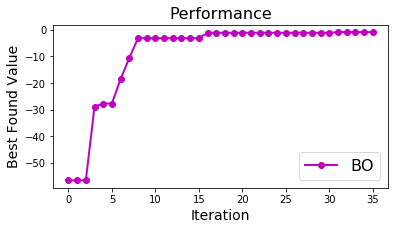

In [7]:
fig=plt.figure(figsize=(6, 3))
myYbest=[bo.Y_ori[:idx+1].max() for idx,val in enumerate(bo.Y_ori)]
plt.plot(range(len(myYbest)),myYbest,linewidth=2,color='m',linestyle='-',marker='o',label='BO')


plt.xlabel('Iteration',fontsize=14)
plt.ylabel('Best Found Value',fontsize=14)
plt.legend(prop={'size': 16})
plt.title('Performance',fontsize=16)

# Run Random Search Baseline

In [8]:
# number of points
n_point=len(bo.Y_ori) 

# uniformly select the input
X_rand = np.random.uniform(myfunction.bounds[:, 0], myfunction.bounds[:, 1],size=(n_point, myfunction.input_dim))

# evaluate the black-box function
Y_rand=myfunction.func(X_rand)


# Comparing Bayes Opt with Random Search

Text(0.5, 1.0, 'Performance')

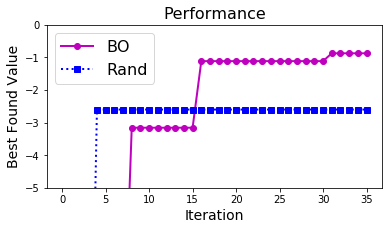

In [13]:
fig=plt.figure(figsize=(6, 3))

myYbest_BO=[bo.Y_ori[:idx+1].max() for idx,val in enumerate(bo.Y_ori)]
plt.plot(range(len(myYbest_BO)),myYbest_BO,linewidth=2,color='m',linestyle='-',marker='o',label='BO')


myYbest_Rand=[Y_rand[:idx+1].max() for idx,val in enumerate(Y_rand)]
plt.plot(range(len(myYbest_Rand)),myYbest_Rand,linewidth=2,color='b',linestyle=':',marker='s',label='Rand')

#plt.hlines(y=myfunction.ismax*myfunction.fstar,xmin=0,xmax=len(myYbest),label='f*')

plt.ylim([-5,0])
plt.xlabel('Iteration',fontsize=14)
plt.ylabel('Best Found Value',fontsize=14)
plt.legend(prop={'size': 16})
plt.title('Performance',fontsize=16)

# Most of the time, BayesOpt will outperform Random Search